# Clustering with k-means and k-mediod algorithms

K-means and k-medidd are the most basic unsupervised clustering algorithms.

## k-means

* define any k value as number of clusters that we would like to output
* randomly choose k points from dataset as initial cluster centroids
* until mean values no longer change
  * assign each point in set to their nearest centroid
  * calculate mean points for each k cluster
  * assign each point to their closest mean values

Firstly, lets load our perviously saved [pca-reduced dataset](005-pca.ipynb).

In [302]:
rm(list=ls())
load("/tmp/reduced-iris.RData")
print(head(data))

          [,1]       [,2]
[1,] -2.684126 -0.3193972
[2,] -2.714142  0.1770012
[3,] -2.888991  0.1449494
[4,] -2.745343  0.3182990
[5,] -2.728717 -0.3267545
[6,] -2.280860 -0.7413304


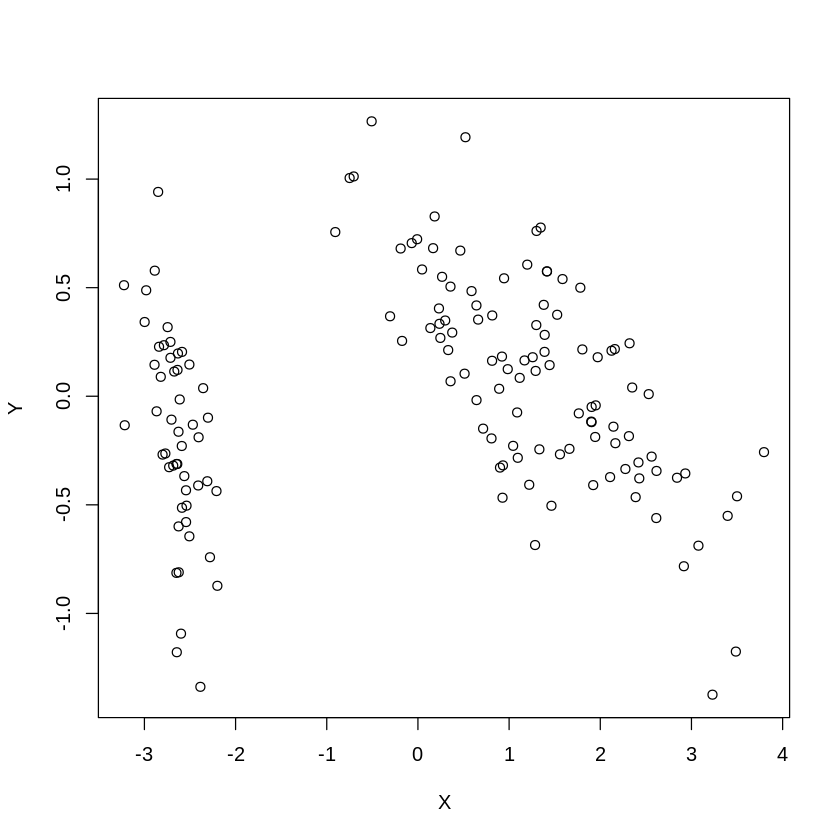

In [303]:
plot(data, xlab = "X", ylab = "Y")

We would like to identify those two clusters with no human intervention. Since we rarely know the "correct" k before clustering, I will choose higher k on purpose.

In [304]:
k <- 3

initial <- sample(nrow(data), size = k, replace = TRUE)
print(initial)

[1]  94 146   9


Generate distance matrix, filter out only distances from initial points and select smallest value. 

In [305]:
d <- dist(data, method = "euclidean", diag = TRUE)
d <- as.matrix(d)
d <- d[initial,]

print(d)
labels <- apply(d, 2, which.min)

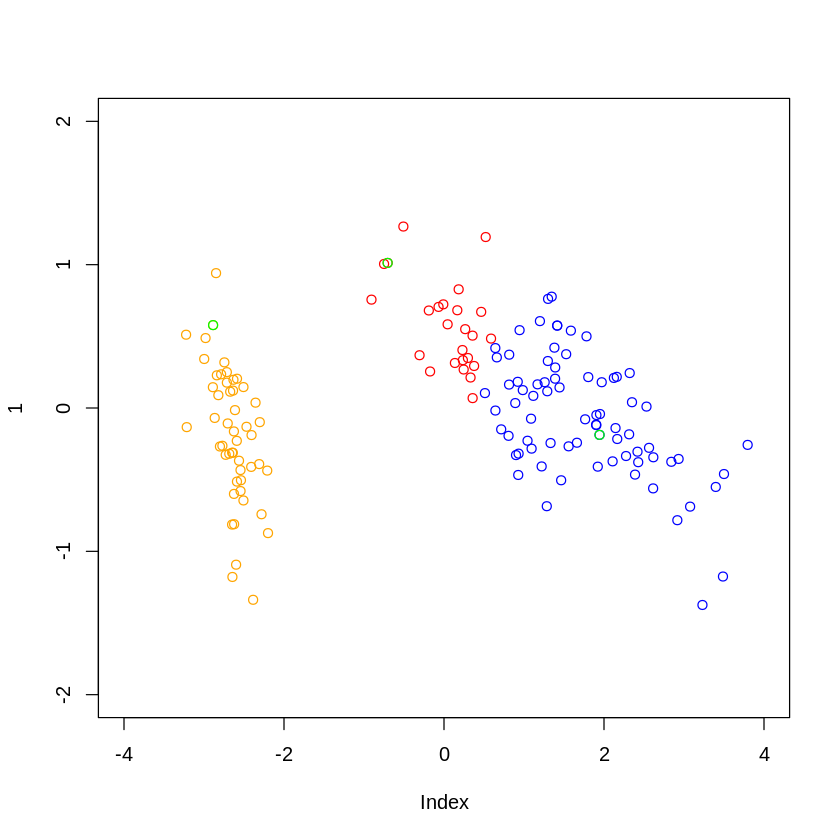

In [306]:
data <- cbind(data, labels)

first <- data[data[, "labels"] == 1,]
second <- data[data[, "labels"] == 2,]
third <- data[data[, "labels"] == 3,]

plot(1, col = "green", xlim = c(-4,4), ylim = c(-2,2), type = "n" )

points(first[,-3], col= "red")
points(second[,-3], col = "blue")
points(third[,-3], col = "orange")

points(data[initial,], col = "green")

Note that initial guesses are usually pretty bad. Now we have to calculate central coordinates for each cluster. And assign each point to closest centroid again.

In [295]:
myFastEucledian <- function(A, B) {
    return(sqrt(sum(( A - B )^2)))
}
distanceToCentroids <- function(x, means) {
    dists <- apply(means, 1, myFastEucledian, B = x)
    return(dists)
}

In [296]:
centroids <- matrix(,ncol = 2, nrow = k)
for (i in seq(1:k)){
    cluster <- data[data[, "labels"] == i,]
    cluster <- cluster[,-3]
    centroids[i,] <- colMeans(cluster)
}

distances <- apply(data[,-3], 1, distanceToCentroids, means = centroids)
print(head(t(distances)))

       [,1]     [,2]      [,3]
1 1.0418028 4.453602 1.1439294
2 0.7706369 4.483276 1.2132201
3 0.9454202 4.656292 1.3741993
4 0.7600598 4.524316 1.2893638
5 1.0770254 4.498539 1.1891046
6 1.2397375 4.098860 0.9295943


In [297]:
labels <- apply(distances, 2, which.min)

This procedure will be repeated until mean values no longer change. Note that this method does not guarantee that global optimum is reached. I.e., different results can be achieved depending where initial centroids landed.

## k-medoid

This algorithm is very similar to k-means but centroids are chosen from the data set. While k-means simply used mean points that may or may not belong to the original set, k-medoid always chooses centroids from original set and partitions non-centroids around them. This approach is also known as "Partitioning Around Medoids", or PAM, and is less sensitive to outliers.

Initially, everything is the same as k-means.

In [298]:
rm(list=ls())
load("/tmp/reduced-iris.RData")

In [299]:
k <- 3
centroids <- sample(nrow(data), size = k, replace = TRUE)

In [300]:
d <- dist(data, method = "euclidean")
d <- as.matrix(d)
d <- d[centroids,]
labels <- apply(d, 2, which.min)

Since medoids are chosen from original set, there is no need to recalculate distances on every iteration. We simply have to choose correct distance from matrix. With k-medoid we can use this logic on every iteration. 

PAM approach is to swap centroid points with non-centroid points and calculate the cost of this operation. If cost increases, then we will undo the swap. Otherwise the centroid will be replaced with new point and we will repartition the data around new centers of mass. This cost is a simple sum of all pointwise distances within the cluster.

In [301]:
iter <- 0
repeat {
    iter = iter + 1
    
    # We may end up with previously tried points, but I don't care
    newMeds <- sample(nrow(data), size = k, replace = TRUE)
    
    print("-----")
    print(newMeds)
    print(centroids)
    
    # upper bound against infinite loop
    if (iter == 10) break
}

[1] "-----"
[1] 143  78  39
[1] 148 132 138
[1] "-----"
[1] 109 135  55
[1] 148 132 138
[1] "-----"
[1] 124  31   3
[1] 148 132 138
[1] "-----"
[1] 141 102 130
[1] 148 132 138
[1] "-----"
[1]  67 116 149
[1] 148 132 138
[1] "-----"
[1] 68 96 76
[1] 148 132 138
[1] "-----"
[1]  69  91 105
[1] 148 132 138
[1] "-----"
[1] 86 80 17
[1] 148 132 138
[1] "-----"
[1] 143 141  39
[1] 148 132 138
[1] "-----"
[1]   4  13 142
[1] 148 132 138


In [208]:
findNonZeroSmallestIdx <- function(x){
  return(which(x==min(x[x>0]))[1])
}
findRandomElement <- function(x){
  return(match(sample(x, 1), x))
}
interClassDistSum <- function(k, distances, labels) {
  interCost <- c(rep(0,k))
  for ( i in seq_along(1:k)) {
    interCost[i] <- sum(d[i ,which(labels == i)])
  }
  return(interCost)
}

In [218]:
mykmedoid <- function(data, dist, k=3, max=1000, maxConv=15) {
  med_idx <- sample(nrow(data), size = k, replace = TRUE)
  d1 <- dist[med_idx,]
  conv <- 0
  iter <- 0
  repeat {
    iter = iter + 1
    labels <- apply(d1, 2, findNonZeroSmallestIdx)
    
    newmed_idx <- apply(d1, 1, findRandomElement)
    d2 <- dist[newmed_idx,]
    labels2 <- apply(d2, 2, findNonZeroSmallestIdx)
    
    cost1 <- interClassDistSum(k, d1, labels)
    cost2 <- interClassDistSum(k, d2, labels2)
    
    if (sum(cost2) < sum(cost1)) {
      labels <- labels2
      d1 <- d2
      med_idx <- newmed_idx
      conv <- 0
    } else {
      conv <- conv + 1
    }
    
    if (conv == maxConv) break
    if (iter == max) break
  }
  return(labels)
}

In [219]:
d <- dist(data, method = "euclidean", diag = TRUE, upper = TRUE)
labels <- mykmedoid(data, d, k = 3, max = 1000, maxConv = 15)

ERROR: Error in dist[med_idx, ]: incorrect number of dimensions
